In [2]:
print('programa iniciado: RF')

programa iniciado: RF


In [3]:
from astropy.io import fits
from glob import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy.utils.data import get_pkg_data_filename
from astropy.convolution import convolve, Gaussian1DKernel
import pyspeckit
from scipy.ndimage import convolve
from scipy.integrate import trapz
import h2o
from h2o.estimators.deeplearning import H2ODeepLearningEstimator
from h2o.estimators import H2ORandomForestEstimator
from h2o.automl import H2OAutoML
from scipy.stats import f_oneway
import random

import matplotlib.pyplot as plt
from keras.layers import Dropout
from keras.layers import BatchNormalization

from astropy.io import fits
import pandas as pd
import matplotlib.pyplot as plt
from astropy.table import Table

from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from scipy.stats import chisquare
from scipy.interpolate import interp1d

from sklearn.metrics import confusion_matrix
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split

import pickle
import joblib

In [4]:
print('modulos cargados')

modulos cargados


In [5]:
### We will attempt to do it automatically for all standardized spectra

In [6]:
wave= fits.open('B_R_Z_wavelenght.fits')
Bwave = wave[1].data
Rwave = wave[2].data
Zwave = wave[3].data
wavelenght = np.hstack((Bwave, Rwave, Zwave)) #Contiene la cadena completa de longitudes de onda B+Z+R para cada espectro

In [7]:
archivos= ['DataDESI_76.fits', 'DataDESI_152.fits', 'DataDESI_213.fits', 'DataDESI_284.fits', 'DataDESI_351.fits',
           'DataDESI_438.fits', 'DataDESI_530.fits', 'DataDESI_606.fits', 'DataDESI_690.fits', 'DataDESI_752.fits']
#archivos= ['DataDESI_752.fits']

#Generamos las listas con los datos:
spectra = None #Este tensor contiene los elementos de flujo completo R+Z+B
spectype = np.array([])  # Esta lista contiene las etiquetas para el ejercicio de clasificación
z = np.array([]) #Esta matriz contiene los corrimientos z para el ejercicio de regresion

for h in range(len(archivos)):
    espc = fits.open(archivos[h]) #open file
    len_espc= len(espc[2].data)
    
    #leemos la informacion
    Bflux= espc[2].data
    Rflux= espc[3].data
    Zflux= espc[4].data
    
    spectrum = np.hstack((Bflux, Rflux, Zflux)) #Contiene la cadena completa de flujo B+Z+R para cada espectro

    if spectra is None:
        spectra = spectrum
    else:
        spectra = np.concatenate((spectra, spectrum), axis=0)

    # Obtener la clase espectral y corrimiento para cada espectro
    clases_espectrales = Table.read(espc, hdu=1)['SPECTYPE'].data
    corrimiento = Table.read(espc, hdu=1)['Z'].data
    
    spectype = np.append(spectype,clases_espectrales)
    z = np.append(z, corrimiento)
    z = z.reshape(-1,1)

# Tenemos el tensor spectra que contiene todos los flujos de los .fits seleccionados
# spectype es una lista con las etiquetas de dichos espectros
# z una matriz con los valores de corrimiento de cada espectro.

In [8]:
indices = [index for index, value in enumerate(spectype) if value == 'GALAXY']
spectra_galaxy = np.array([spectra[index] for index in indices])

In [9]:
indices = [index for index, value in enumerate(spectype) if value == 'QSO']
spectra_qso = np.array([spectra[index] for index in indices])

In [10]:
indices = [index for index, value in enumerate(spectype) if value == 'STAR']
spectra_star = np.array([spectra[index] for index in indices])

In [11]:
#spectra= spectra[:500]
#spectype= spectype[:500]

In [12]:
print('spectra y etiquetas creados')

spectra y etiquetas creados


In [13]:
### We calculate the features

In [14]:
#flujos dentro de las bandas ugriz y sinteticas
FLUX_U=np.array([])
FLUX_G=np.array([])
FLUX_R=np.array([])
FLUX_I=np.array([])
FLUX_Z=np.array([])
F0=np.array([])
F1=np.array([])
F2=np.array([])
F3=np.array([])

mascara_U = (wavelenght >= 3055.11) & (wavelenght <= 4030.64)
mascara_G = (wavelenght >= 3797.64) & (wavelenght <= 5553.04)
mascara_R = (wavelenght >= 5418.23) & (wavelenght <= 6994.42)
mascara_I = (wavelenght >= 6692.41) & (wavelenght <= 8400.32)
mascara_Z = (wavelenght >= 8385) & (wavelenght <= 9875)
mascara_F0 = (wavelenght >= 3055.11) & (wavelenght <= 3756)
mascara_F1 = (wavelenght >= 5578) & (wavelenght <= 5582)
mascara_F2 = (wavelenght >= 7601) & (wavelenght <= 7603)
mascara_F3 = (wavelenght >= 9310) & (wavelenght <= 9570)

wavelenght_filtrado_U= wavelenght[mascara_U]
wavelenght_filtrado_G= wavelenght[mascara_G]
wavelenght_filtrado_R= wavelenght[mascara_R]
wavelenght_filtrado_I= wavelenght[mascara_I]
wavelenght_filtrado_Z= wavelenght[mascara_Z]
wavelenght_filtrado_F0= wavelenght[mascara_F0]
wavelenght_filtrado_F1= wavelenght[mascara_F1]
wavelenght_filtrado_F2= wavelenght[mascara_F2]
wavelenght_filtrado_F3= wavelenght[mascara_F3]

#Curvatura
CURV=np.array([])

def func(x, a, b, c):
    return a * x**2 + b * x + c

#MAD
MAD=np.array([])

#Chi cuadrado
CHI_GALAXY=np.array([])
CHI_QSO=np.array([])
CHI_STAR=np.array([])

spectra_galaxy_mean = np.mean(spectra_galaxy, axis=0)
spectra_qso_mean = np.mean(spectra_qso, axis=0)
spectra_star_mean = np.mean(spectra_star, axis=0)

#ABBE
ABBE=np.array([])

#RANDOM
ALEATORIO=np.array([])
random.seed(42)

#Recorremos cada espectro y calculamos las features que iran dentro de las listas de arriba
for spectrum in spectra:
    #Flujos
    espectro_filtrado_U= spectrum[mascara_U]
    espectro_filtrado_G= spectrum[mascara_G]
    espectro_filtrado_R= spectrum[mascara_R]
    espectro_filtrado_I= spectrum[mascara_I]
    espectro_filtrado_Z= spectrum[mascara_Z]
    espectro_filtrado_F0= spectrum[mascara_F0]
    espectro_filtrado_F1= spectrum[mascara_F1]
    espectro_filtrado_F2= spectrum[mascara_F2]
    espectro_filtrado_F3= spectrum[mascara_F3]
    
    area_U= trapz(espectro_filtrado_U, wavelenght_filtrado_U)
    area_G= trapz(espectro_filtrado_G, wavelenght_filtrado_G)
    area_R= trapz(espectro_filtrado_R, wavelenght_filtrado_R)
    area_I= trapz(espectro_filtrado_I, wavelenght_filtrado_I)
    area_Z= trapz(espectro_filtrado_Z, wavelenght_filtrado_Z)
    area_F0= trapz(espectro_filtrado_F0, wavelenght_filtrado_F0)
    area_F1= trapz(espectro_filtrado_F1, wavelenght_filtrado_F1)
    area_F2= trapz(espectro_filtrado_F2, wavelenght_filtrado_F2)
    area_F3= trapz(espectro_filtrado_F3, wavelenght_filtrado_F3)
    
    FLUX_U= np.append(FLUX_U, area_U)
    FLUX_G= np.append(FLUX_G, area_G)
    FLUX_R= np.append(FLUX_R, area_R)
    FLUX_I= np.append(FLUX_I, area_I)
    FLUX_Z= np.append(FLUX_Z, area_Z)
    F0= np.append(F0, area_F0)
    F1= np.append(F1, area_F1)
    F2= np.append(F2, area_F2)
    F3= np.append(F3, area_F3)

    #Curvatura
    try:
        # Realiza el ajuste de curva a los datos suavizados
        popt, _ = curve_fit(func, wavelenght, spectrum)
        # Obtiene los parámetros ajustados
        a, b, c = popt
        # Calcula la curvatura (segunda derivada)
        curvature = 2 * a
        # Agrega la curvatura al listado
        CURV= np.append(CURV, curvature)
    except RuntimeError:
        # Si no se puede calcular la curvatura, agrega 0
        CURV= np.append(CURV, 0)

    #MAD
    mad = np.median(np.abs(spectrum - np.median(spectrum)))
    MAD= np.append(MAD, mad)

    #Chi cuadrado con plantillas
    chi_qso =  np.sum(((spectrum - spectra_qso_mean)**2)/spectra_qso_mean) 
    chi_galaxy = np.sum(((spectrum - spectra_galaxy_mean)**2)/spectra_galaxy_mean) 
    chi_star = np.sum(((spectrum - spectra_star_mean)**2)/spectra_star_mean)

    CHI_GALAXY= np.append(CHI_GALAXY, chi_galaxy)
    CHI_QSO= np.append(CHI_QSO, chi_qso)
    CHI_STAR= np.append(CHI_STAR, chi_star)

    #ABBE
    parte_1 = (len(spectrum)/(2*(len(spectrum)-1))) * (1/(np.sum((spectrum-np.mean(spectrum))**2)))
    parte_2 = 0
    for i in range(len(spectrum)-1):
        parte_2 += (spectrum[i+1]-spectrum[i])**2
    abbe = parte_1 * parte_2
    ABBE= np.append(ABBE, abbe)

    #RANDOM
    ALEATORIO= np.append(ALEATORIO, random.random())


#Calculamos los indices de color

U_R = FLUX_U-FLUX_R 
U_G = FLUX_U-FLUX_G
G_Z = FLUX_G-FLUX_Z
R_Z = FLUX_R-FLUX_Z
I_Z = FLUX_I-FLUX_Z

#Calculamos las razones entre los flujos ugriz y sinteticos

RU= FLUX_R/FLUX_U
GZ= FLUX_G/FLUX_Z
RZ= FLUX_R/FLUX_Z
IZ= FLUX_I/FLUX_Z
UG= FLUX_U/FLUX_G
UZ= FLUX_U/FLUX_Z

_0Z= F0/FLUX_Z
_0G= F0/FLUX_G
_0R= F0/FLUX_R
_0I= F0/FLUX_I
_01= F0/F1
_02= F0/F2
_03= F0/F3
_1U= F1/FLUX_U
_1Z= F1/FLUX_Z
_1R= F1/FLUX_R
_1I= F1/FLUX_I
_12= F1/F2
_2Z= F2/FLUX_Z
_2R= F2/FLUX_R
_2I= F2/FLUX_I
_23= F2/F3
_3U= F3/FLUX_U
_3Z= F3/FLUX_Z
_3R= F3/FLUX_R
_3I= F3/FLUX_I

G_Z_R_Z= (G_Z)/(R_Z)

#Calculamos la razon entre los valores de chi cuadrado
CHI_GALAXYQSO= CHI_GALAXY/CHI_QSO
CHI_GALAXYSTAR= CHI_GALAXY/CHI_STAR
CHI_QSOSTAR= CHI_QSO/CHI_STAR

#Temperatura de color
T_UR= -2.5*np.log10(np.abs(FLUX_U/FLUX_R))
T_UG= -2.5*np.log10(np.abs(FLUX_U/FLUX_G))
T_GZ= -2.5*np.log10(np.abs(FLUX_G/FLUX_Z))
T_RZ= -2.5*np.log10(np.abs(FLUX_R/FLUX_Z))
T_IZ= -2.5*np.log10(np.abs(FLUX_I/FLUX_Z))


In [15]:
print('features calculadas')

features calculadas


In [16]:
### Random Forest

In [17]:
#Haremos que X sea una matriz que contiene todas las features. En donde cada fila corresponde a un objeto distinto,
#y cada columna contiene una #features distinta

In [18]:
# Definir los datos de características (features) y etiquetas
X = np.array([FLUX_U, FLUX_G, FLUX_R, FLUX_I, FLUX_Z, F0, F1, F2, F3, CURV, MAD, CHI_GALAXY, CHI_QSO, CHI_STAR, ABBE, U_R, U_G, 
              G_Z, R_Z, I_Z, RU, GZ, RZ, IZ, UG, UZ, _0Z, _0G, _0R, _0I, _01, _02, _03, _1U, _1Z, _1R, _1I, _12, _2Z, _2R, _2I,
              _23, _3U, _3Z, _3R, _3I, G_Z_R_Z, CHI_GALAXYQSO, CHI_GALAXYSTAR, CHI_QSOSTAR, T_UR, T_UG, T_GZ, T_RZ, T_IZ, ALEATORIO])
X = X.T
y = spectype

# Cargar el modelo desde el archivo .pkl
model = joblib.load('best_random_forest_model.pkl')

# Realizar predicciones
predictions = model.predict(X)

accuracy = accuracy_score(y, predictions)
print("Overall accuracy:", accuracy)

Overall accuracy: 0.9880697590642283


In [19]:
# Obtener las probabilidades de predicción
predicted_probabilities = model.predict_proba(X)

# Las probabilidades predichas para cada clase están en predicted_probabilities
# La matriz tendrá filas para cada instancia en X y columnas para cada clase en y

# Para obtener las probabilidades de la clase específica, por ejemplo, galaxia, quasar y estrella
galaxy_probability = predicted_probabilities[:, 0]  # Probabilidades de ser una galaxia
quasar_probability = predicted_probabilities[:, 1]  # Probabilidades de ser un quasar
star_probability = predicted_probabilities[:, 2]    # Probabilidades de ser una estrella

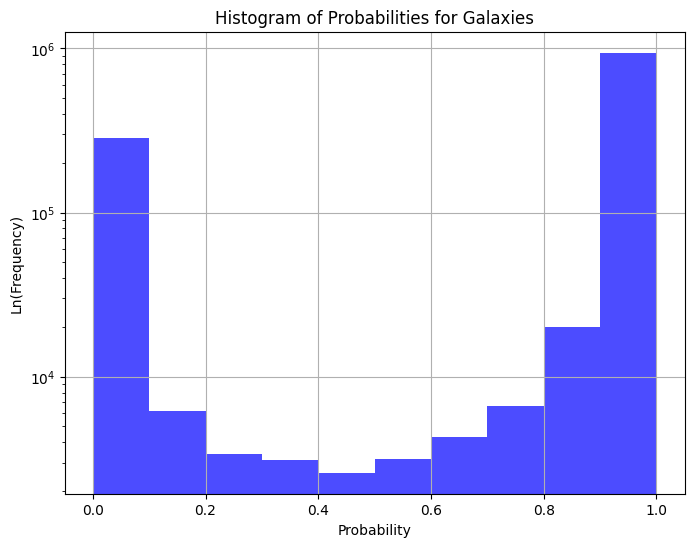

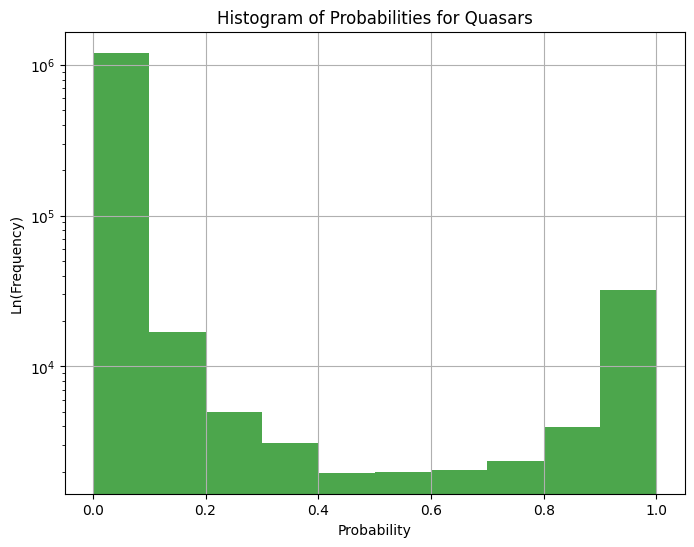

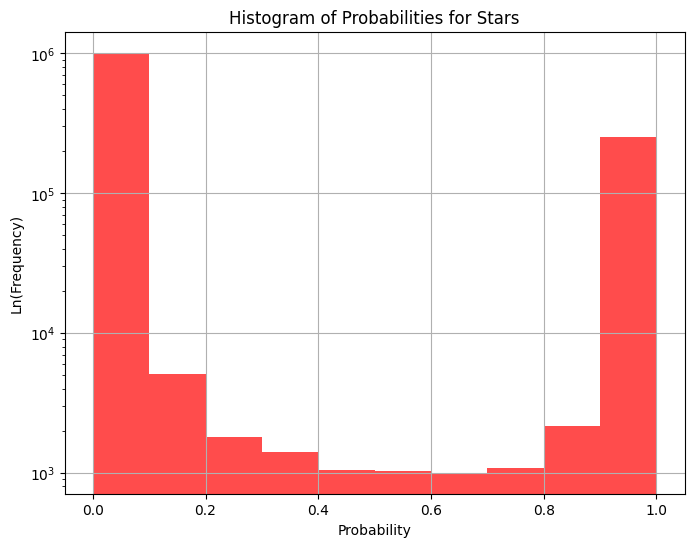

In [23]:
# Crear histograma para las probabilidades de galaxia
plt.figure(figsize=(8, 6))
plt.hist(galaxy_probability, bins=10, color='blue', alpha=0.7)
plt.yscale('log')  # Establecer el eje Y en escala logarítmica
plt.title('Histogram of Probabilities for Galaxies')
plt.xlabel('Probability')
plt.ylabel('Ln(Frequency)')
plt.grid(True)
plt.show()

# Crear histograma para las probabilidades de quasar
plt.figure(figsize=(8, 6))
plt.hist(quasar_probability, bins=10, color='green', alpha=0.7)
plt.yscale('log')  # Establecer el eje Y en escala logarítmica
plt.title('Histogram of Probabilities for Quasars')
plt.xlabel('Probability')
plt.ylabel('Ln(Frequency)')
plt.grid(True)
plt.show()

# Crear histograma para las probabilidades de estrella
plt.figure(figsize=(8, 6))
plt.hist(star_probability, bins=10, color='red', alpha=0.7)
plt.yscale('log')  # Establecer el eje Y en escala logarítmica
plt.title('Histogram of Probabilities for Stars')
plt.xlabel('Probability')
plt.ylabel('Ln(Frequency)')
plt.grid(True)
plt.show()

Model metrics:
              precision    recall  f1-score   support

      GALAXY       0.99      1.00      0.99    964814
         QSO       0.97      0.81      0.88     51221
        STAR       1.00      0.99      0.99    258122

    accuracy                           0.99   1274157
   macro avg       0.98      0.93      0.95   1274157
weighted avg       0.99      0.99      0.99   1274157



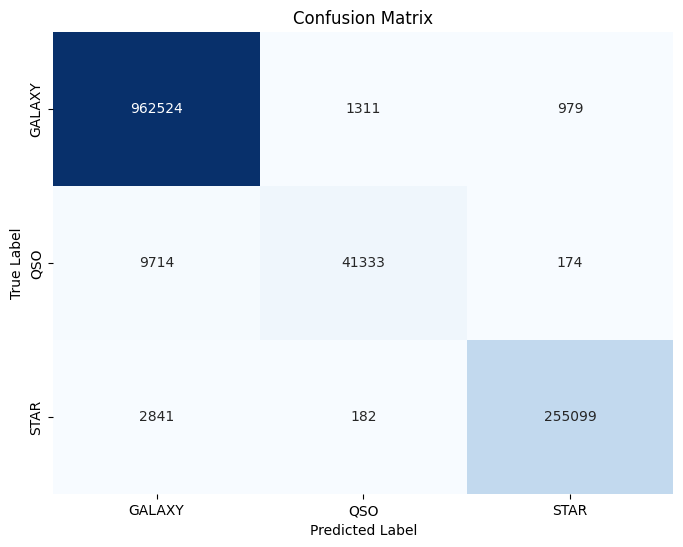

In [24]:
# Calcular las métricas globales del modelo
print("Model metrics:")
print(classification_report(y, predictions))


# Definir los nombres de las clases
class_names = ['GALAXY', 'QSO', 'STAR']
# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y, predictions)

# Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

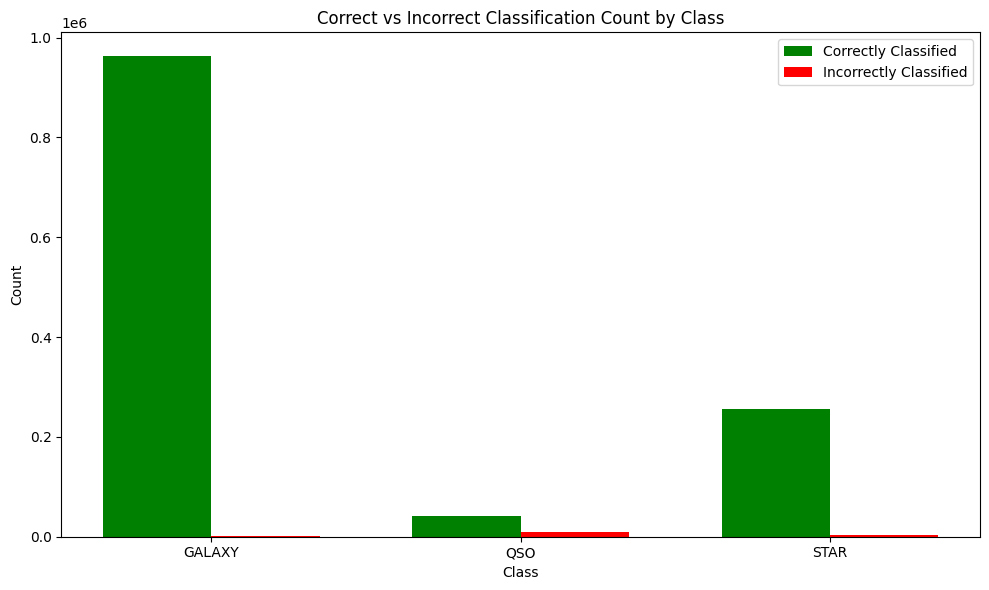

In [25]:
# Obtener las etiquetas verdaderas y las predicciones del modelo
true_labels = y
predicted_labels = predictions

# Inicializar contadores para clasificaciones correctas e incorrectas por clase
correct_counts = {'GALAXY': 0, 'QSO': 0, 'STAR': 0}
incorrect_counts = {'GALAXY': 0, 'QSO': 0, 'STAR': 0}

# Calcular clasificaciones correctas e incorrectas para cada clase
for true_label, predicted_label in zip(true_labels, predicted_labels):
    if true_label == predicted_label:
        correct_counts[true_label] += 1
    else:
        incorrect_counts[true_label] += 1

# Clases
classes = ['GALAXY', 'QSO', 'STAR']
x_pos = np.arange(len(classes))

# Obtener las alturas de las barras
correct_heights = [correct_counts[c] for c in classes]
incorrect_heights = [incorrect_counts[c] for c in classes]

# Configurar la anchura de las barras
bar_width = 0.35

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(x_pos, correct_heights, bar_width, label='Correctly Classified', color='g')
plt.bar(x_pos + bar_width, incorrect_heights, bar_width, label='Incorrectly Classified', color='r')

# Etiquetas y título
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Correct vs Incorrect Classification Count by Class')
plt.xticks(x_pos + bar_width / 2, classes)
plt.legend()
# Mostrar el gráfico
plt.tight_layout()
plt.savefig('hist_accuracy_RF')
plt.show()
plt.close()